In [720]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



## Part 1

In [721]:
df = pd.read_csv("cleveland.csv")

In [722]:
df = df.rename({"num": "disease"}, axis=1)
df["disease"] = df["disease"].apply(lambda x: min(x, 1))
df
df.replace("?", pd.NA, inplace=True)
df = df.dropna()
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


### Standardization

In [723]:
df["thalach"] = (df.thalach - df.thalach.mean()) / df.thalach.std()
df["exang"] = (df.exang - df.exang.mean()) / df.exang.std()
df["oldpeak"] = (df.oldpeak - df.oldpeak.mean()) / df.oldpeak.std()
df["ca"] = df["ca"].astype("float")
df["thal"] = df["thal"].astype("float")
df["ca"] = (df.ca - df.ca.mean()) / df.ca.std()
df["thal"] = (df.thal - df.thal.mean()) / df.thal.std()
df["age"] = (df.age - df.age.mean()) / df.age.std()
df["sex"] = (df.sex - df.sex.mean()) / df.sex.std()
df["cp"] = (df.cp - df.cp.mean()) / df.cp.std()
df["trestbps"] = (df.trestbps - df.trestbps.mean()) / df.trestbps.std()
df["chol"] = (df.chol - df.chol.mean()) / df.chol.std()
df["fbs"] = (df.fbs - df.fbs.mean()) / df.fbs.std()
df["restecg"] = (df.restecg - df.restecg.mean()) / df.restecg.std()
df["slope"] = (df.slope - df.slope.mean()) / df.slope.std()

### Let's try the correlation plot to see which features have a great slope value

<AxesSubplot: xlabel='disease', ylabel='thal'>

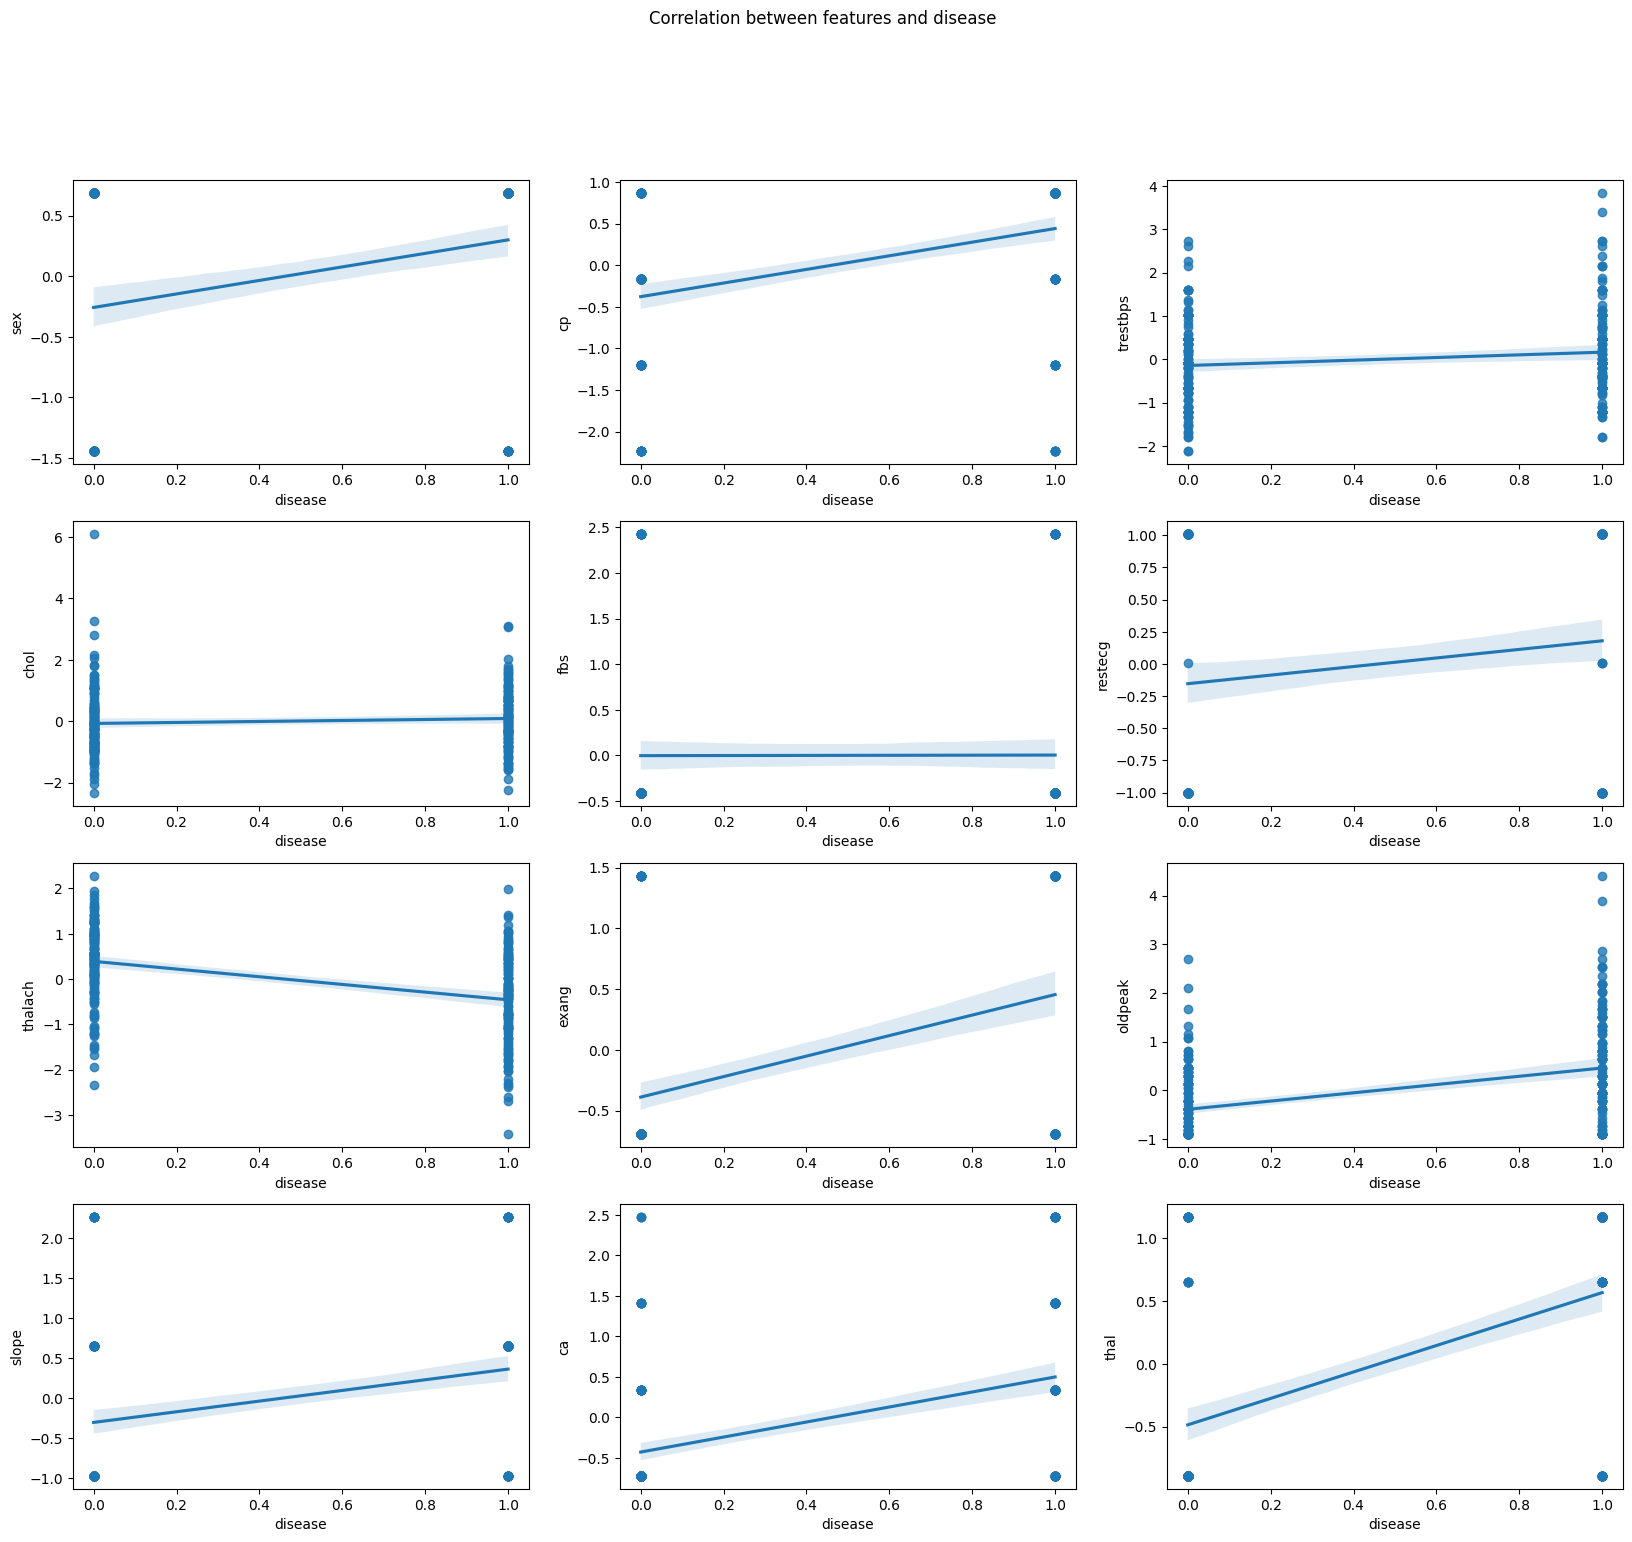

In [724]:
fig, axes = plt.subplots(4, 3, figsize=(20, 17), sharex=False)
fig.suptitle('Correlation between features and disease')
sns.regplot(x='disease', y='sex', data=df, ax=axes[0,0])
sns.regplot(x='disease', y='cp', data=df, ax=axes[0,1])
sns.regplot(x='disease', y='trestbps', data=df, ax=axes[0,2])
sns.regplot(x='disease', y='chol', data=df, ax=axes[1,0])
sns.regplot(x='disease', y='fbs', data=df, ax=axes[1,1])
sns.regplot(x='disease', y='restecg', data=df, ax=axes[1,2])
sns.regplot(x='disease', y='thalach', data=df, ax=axes[2,0])
sns.regplot(x='disease', y='exang', data=df, ax=axes[2,1])
sns.regplot(x='disease', y='oldpeak', data=df, ax=axes[2,2])
sns.regplot(x='disease', y='slope', data=df, ax=axes[3,0])
sns.regplot(x='disease', y='ca', data=df, ax=axes[3,1])
sns.regplot(x='disease', y='thal', data=df, ax=axes[3,2])

### Let's take a look at scatter plot to see if there is any pattern

<AxesSubplot: xlabel='age', ylabel='thal'>

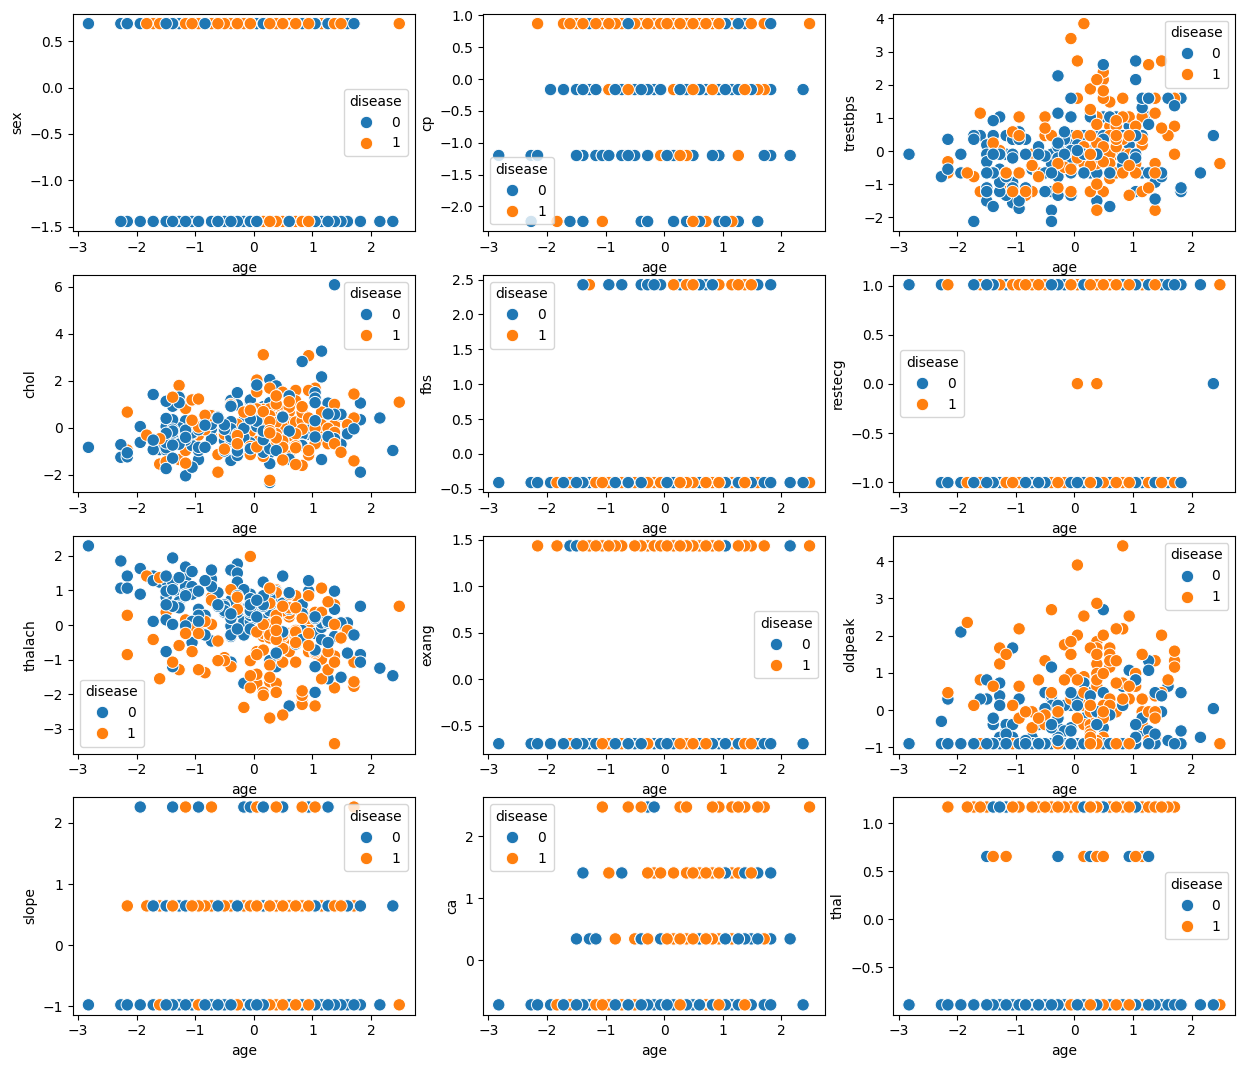

In [768]:
figs, axes = plt.subplots(4, 3, figsize=(15, 13), sharex=False)

sns.scatterplot(x='age', y='sex', data=df, hue='disease', ax=axes[0,0], s=80)
sns.scatterplot(x='age', y='cp', data=df, hue='disease', ax=axes[0,1], s=80)
sns.scatterplot(x='age', y='trestbps', data=df, hue='disease', ax=axes[0,2], s=80)
sns.scatterplot(x='age', y='chol', data=df, hue='disease', ax=axes[1,0], s=80)
sns.scatterplot(x='age', y='fbs', data=df, hue='disease', ax=axes[1,1], s=80)
sns.scatterplot(x='age', y='restecg', data=df, hue='disease', ax=axes[1,2], s=80)
sns.scatterplot(x='age', y='thalach', data=df, hue='disease', ax=axes[2,0], s=80)
sns.scatterplot(x='age', y='exang', data=df, hue='disease', ax=axes[2,1], s=80)
sns.scatterplot(x='age', y='oldpeak', data=df, hue='disease', ax=axes[2,2], s=80)
sns.scatterplot(x='age', y='slope', data=df, hue='disease', ax=axes[3,0], s=80)
sns.scatterplot(x='age', y='ca', data=df, hue='disease', ax=axes[3,1], s=80)
sns.scatterplot(x='age', y='thal', data=df, hue='disease', ax=axes[3,2], s=80)

#### Based on these charts the features: thalach, exang, oldpeak, ca, and thal have the biggest abstract correlation slope value. Also, based on the scatter plot we can see if there is any pattern between features for example between "age" and "thal" we can see in any age if "thal" is above 1 (which is our standardized metric) the disease is likely positive.

### Distribution of the features over class label

In [742]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'disease'],
      dtype='object')

C:\Users\Sadra\AppData\Local\Temp\ipykernel_7940\3610063002.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(disease_1.age, label='D', kde_kws={'bw':0.5}, ax=axes[0,0], bins=5)
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2496: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Sadra\AppData\Local\Temp\ipykernel_7940\3610063002.py:6: UserWarnin

<AxesSubplot: xlabel='thal', ylabel='Density'>

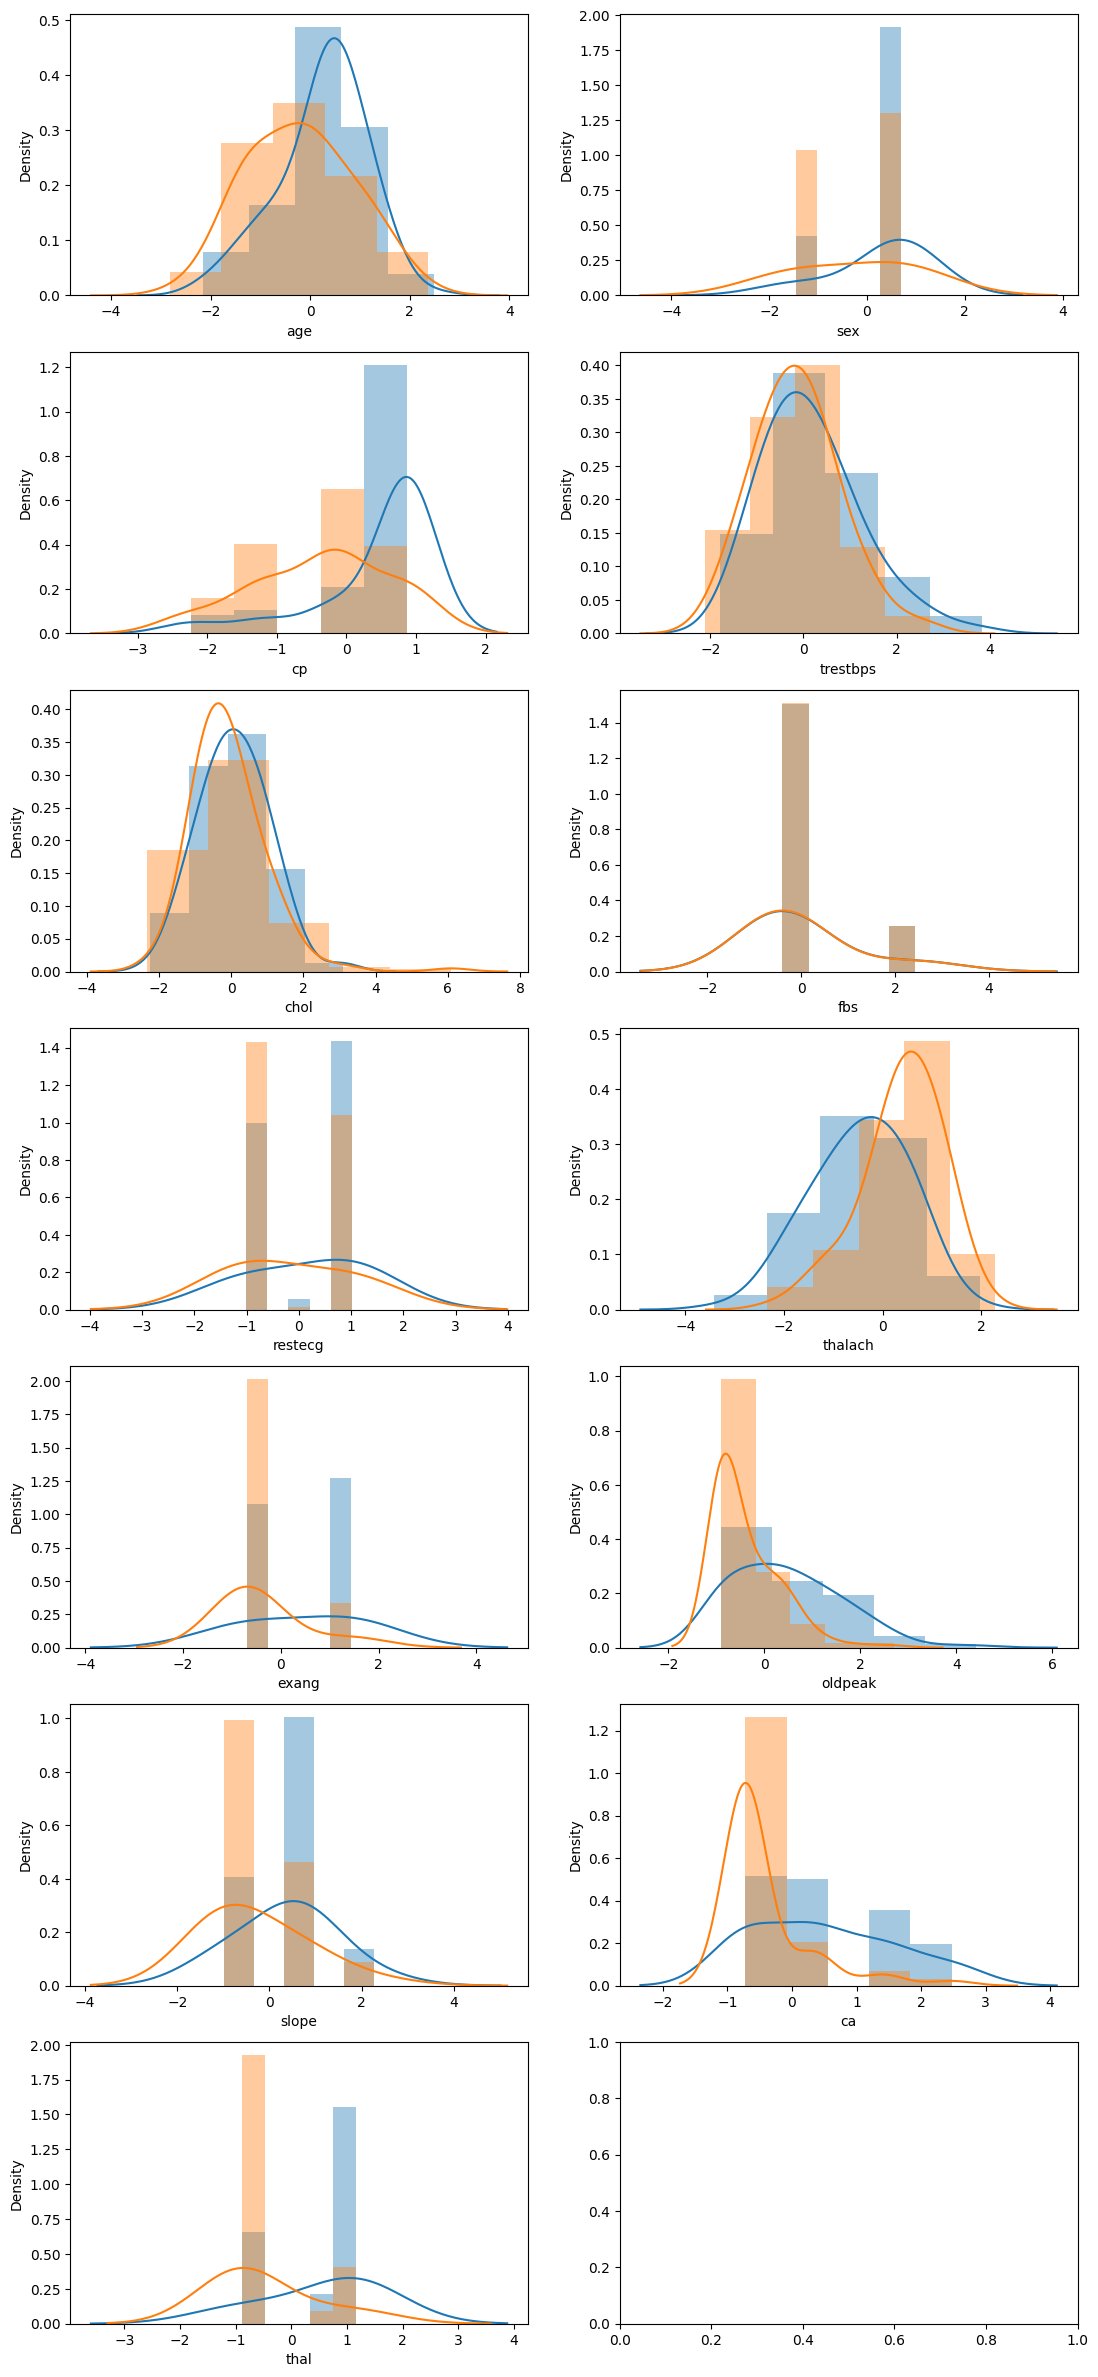

In [743]:
disease_1 = df[df.disease==1]
disease_0 = df[df.disease==0]
figs, axes = plt.subplots(7, 2, figsize=(13, 30), sharex=False)

sns.distplot(disease_1.age, label='D', kde_kws={'bw':0.5}, ax=axes[0,0], bins=5)
sns.distplot(disease_0.age, label='H', kde_kws={'bw':0.5}, ax=axes[0,0], bins=5)

sns.distplot(disease_1.sex, label='D', kde_kws={'bw':1}, ax=axes[0,1], bins=5)
sns.distplot(disease_0.sex, label='H', kde_kws={'bw':1}, ax=axes[0,1], bins=5)

sns.distplot(disease_1.cp, label='D', kde_kws={'bw':0.5}, ax=axes[1,0], bins=5)
sns.distplot(disease_0.cp, label='H', kde_kws={'bw':0.5}, ax=axes[1,0], bins=5)

sns.distplot(disease_1.trestbps, label='D', kde_kws={'bw':0.5}, ax=axes[1,1], bins=5)
sns.distplot(disease_0.trestbps, label='H', kde_kws={'bw':0.5}, ax=axes[1,1], bins=5)

sns.distplot(disease_1.chol, label='D', kde_kws={'bw':0.5}, ax=axes[2,0], bins=5)
sns.distplot(disease_0.chol, label='H', kde_kws={'bw':0.5}, ax=axes[2,0], bins=5)

sns.distplot(disease_1.fbs, label='D', kde_kws={'bw':1}, ax=axes[2,1], bins=5)
sns.distplot(disease_0.fbs, label='H', kde_kws={'bw':1}, ax=axes[2,1], bins=5)

sns.distplot(disease_1.restecg, label='D', kde_kws={'bw':1}, ax=axes[3,0], bins=5)
sns.distplot(disease_0.restecg, label='H', kde_kws={'bw':1}, ax=axes[3,0], bins=5)

sns.distplot(disease_1.thalach, label='D', kde_kws={'bw':0.5}, ax=axes[3,1], bins=5)
sns.distplot(disease_0.thalach, label='H', kde_kws={'bw':0.5}, ax=axes[3,1], bins=5)

sns.distplot(disease_1.exang, label='D', kde_kws={'bw':1}, ax=axes[4,0], bins=5)
sns.distplot(disease_0.exang, label='H', kde_kws={'bw':1}, ax=axes[4,0], bins=5)

sns.distplot(disease_1.oldpeak, label='D', kde_kws={'bw':0.5}, ax=axes[4,1], bins=5)
sns.distplot(disease_0.oldpeak, label='H', kde_kws={'bw':0.5}, ax=axes[4,1], bins=5)

sns.distplot(disease_1.slope, label='D', kde_kws={'bw':1}, ax=axes[5,0], bins=5)
sns.distplot(disease_0.slope, label='H', kde_kws={'bw':1}, ax=axes[5,0], bins=5)

sns.distplot(disease_1.ca, label='D', kde_kws={'bw':0.5}, ax=axes[5,1], bins=5)
sns.distplot(disease_0.ca, label='H', kde_kws={'bw':0.5}, ax=axes[5,1], bins=5)

sns.distplot(disease_1.thal, label='D', kde_kws={'bw':1}, ax=axes[6,0], bins=5)
sns.distplot(disease_0.thal, label='H', kde_kws={'bw':1}, ax=axes[6,0], bins=5)

### Selecting our features for further analysis

In [726]:

X = df[['thalach', 'exang', 'oldpeak', 'ca', 'thal']].values
y = df["disease"].values



## k-nearest neighbors function

In [727]:
def knn(n_neighbors, X_train, y_train, X_test, y_test, show_confusion = False):
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean", algorithm="auto")

    fit = nn.fit(X_train)

    distances, indices = fit.kneighbors(X_test)
    y_pred = []

    # print(list(y_test))

    # for i in range(len(X_test)):
    #     zeros = list(y_train.iloc[indices[i]]).count(0)
    #     ones = list(y_train.iloc[indices[i]]).count(1)
    #     if ones > zeros:
    #         y_pred.append(1)
    #     else:
    #         y_pred.append(0)
    for i in range(len(X_test)):
        zeros = list(y_train[indices[i]]).count(0)
        ones = list(y_train[indices[i]]).count(1)
        if ones > zeros:
            y_pred.append(1)
        # In case of equality of numbers we predict zero
        else:
            y_pred.append(0)
    if show_confusion:
        plt.figure(figsize=(5, 5))
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix as heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
    
    (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=[0,1])
    return [p, r, f, s]
    

# Finding the best K

best k -> 29


Text(0, 0.5, 'f-score')

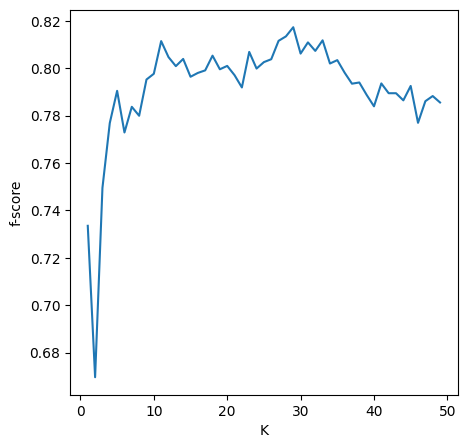

In [728]:
def bestK(n, X, y):
    np.random.seed(40)
    k_fold = 10

    # Calculate the number of samples per fold
    fold_size = len(X) // k_fold
    
    # Shuffle the dataset
    X = np.array(X)
    y = np.array(y)

    # Shuffle the indices array
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Use the shuffled indices to shuffle both X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    f_score_1 = []
    

    for fold in range(k_fold):
        # Split the dataset into training and testing sets for this fold
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size
        X_test_fold = X_shuffled[test_start:test_end]
        y_test_fold = y_shuffled[test_start:test_end]


        # Use the remaining data as training set
        X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
        y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
        result = knn(n, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        # print(result)
        f_score_1.append(result[2][1])
    
    return np.mean(f_score_1)

k_range = range(1, 50)
f_scores = [bestK(n, X, y) for n in k_range]
# print(f_scores)
print(f"best k -> {f_scores.index(max(f_scores)) + 1}")
best_K = f_scores.index(max(f_scores)) + 1
plt.figure(figsize=(5, 5))
plt.plot(k_range, f_scores)
plt.xlabel("K")
plt.ylabel("f-score")




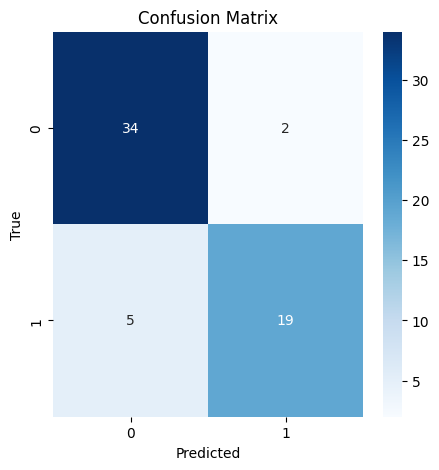

precision=[0.87179487 0.9047619 ], recall=[0.94444444 0.79166667], f-score=[0.90666667 0.84444444], support=[36 24]


In [729]:
# result_list = []
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=19)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
# r = -100000000
# j = 0
# for i in range(1, 51):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=i)
#     s = (knn(best_K, X_train, y_train, X_test, y_test, show_confusion=False)[2][1])
#     if s > r:
#         r = s
#         j = i
result = knn(best_K, X_train, y_train, X_test, y_test, show_confusion=True)
# # print(max(result_list))
# print(j)
# print(r)
print(f'precision={result[0]}, recall={result[1]}, f-score={result[2]}, support={result[3]}') 


### Implementation of K-fold cross validation

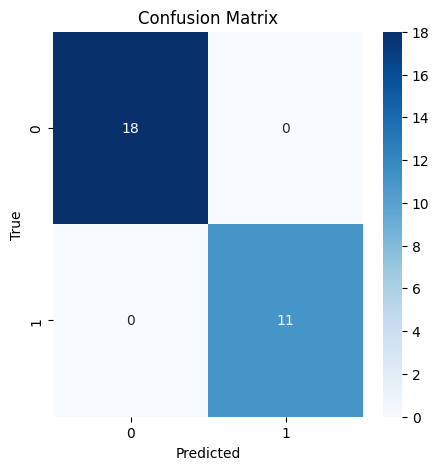

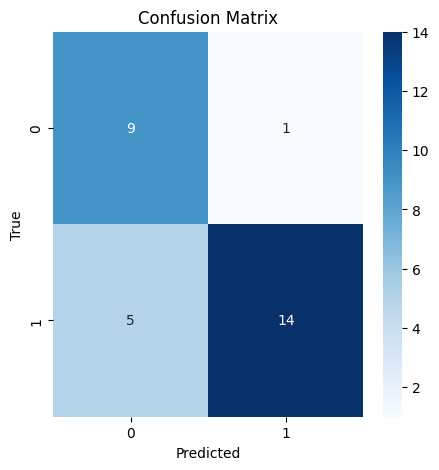

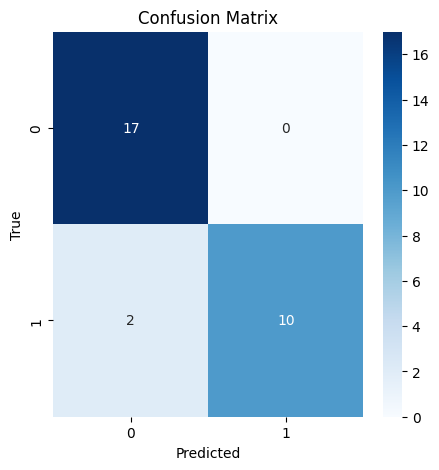

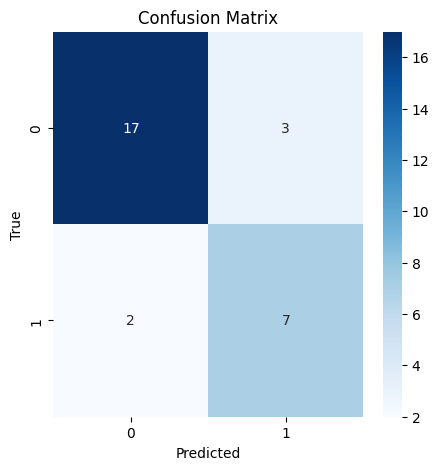

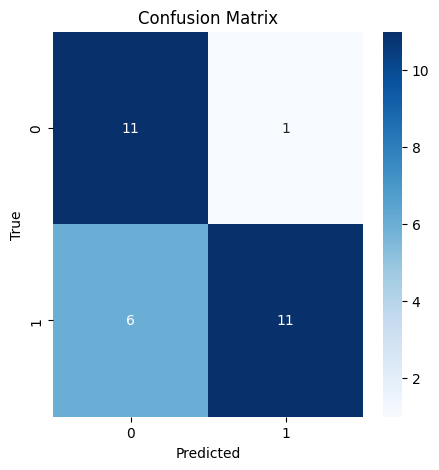

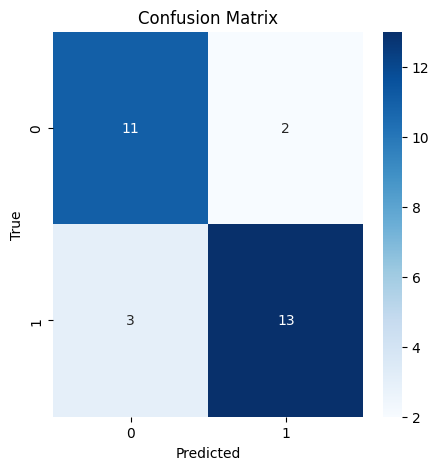

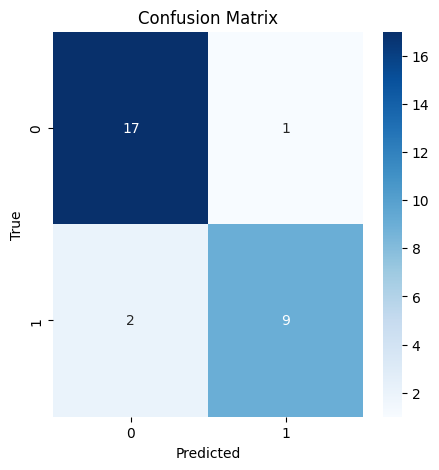

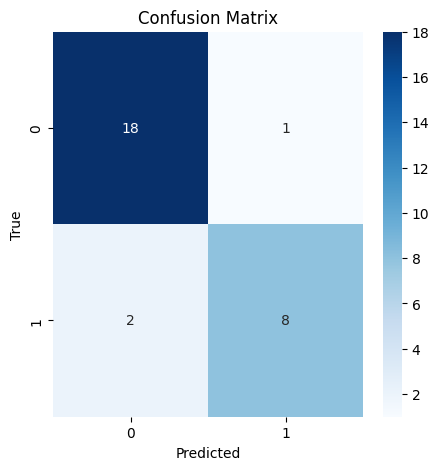

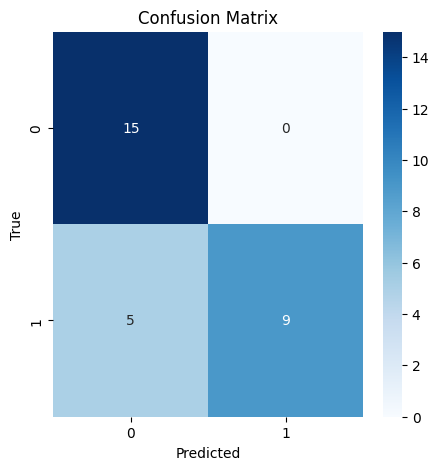

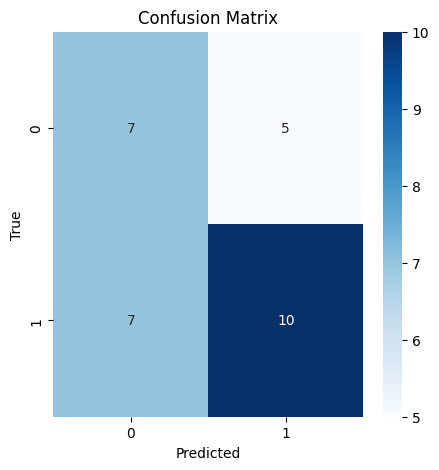

recall_0 -> [1.0, 0.9, 1.0, 0.85, 0.9166666666666666, 0.8461538461538461, 0.9444444444444444, 0.9473684210526315, 1.0, 0.5833333333333334]
mean recall_0 -> 0.8987966711650923
recall_1 -> [1.0, 0.7368421052631579, 0.8333333333333334, 0.7777777777777778, 0.6470588235294118, 0.8125, 0.8181818181818182, 0.8, 0.6428571428571429, 0.5882352941176471]
mean recall_1 -> 0.7656786295060288
precision_0 -> [1.0, 0.6428571428571429, 0.8947368421052632, 0.8947368421052632, 0.6470588235294118, 0.7857142857142857, 0.8947368421052632, 0.9, 0.75, 0.5]
mean precision_0 -> 0.790984077841663
precision_1 -> [1.0, 0.9333333333333333, 1.0, 0.7, 0.9166666666666666, 0.8666666666666667, 0.9, 0.8888888888888888, 1.0, 0.6666666666666666]
mean precision_1 -> 0.8872222222222221
f-score_0 -> [1.0, 0.75, 0.9444444444444444, 0.8717948717948718, 0.7586206896551724, 0.8148148148148148, 0.918918918918919, 0.9230769230769231, 0.8571428571428571, 0.5384615384615384]
mean f-score_0 -> 0.8377275058309541
f-score_1 -> [1.0, 0.8

In [730]:
np.random.seed(40)
k_fold = 10

# Calculate the number of samples per fold
fold_size = len(X) // k_fold

# Shuffle the dataset
X = np.array(X)
y = np.array(y)

# Shuffle the indices array
indices = np.arange(len(X))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle both X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f_score_0 = []
f_score_1 = []
support_0 = []
support_1 = []

for fold in range(k_fold):
    # Split the dataset into training and testing sets for this fold
    test_start = fold * fold_size
    test_end = (fold + 1) * fold_size
    X_test_fold = X_shuffled[test_start:test_end]
    y_test_fold = y_shuffled[test_start:test_end]
    
    
    # Use the remaining data as training set
    X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
    y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
    result = knn(best_K, X_train_fold, y_train_fold, X_test_fold, y_test_fold, show_confusion=True)
    # print(result)
    precision_0.append(result[0][0])
    precision_1.append(result[0][1])
    recall_0.append(result[1][0])
    recall_1.append(result[1][1])
    f_score_0.append(result[2][0])
    f_score_1.append(result[2][1])
    support_0.append(result[3][0])
    support_1.append(result[3][1])

print(f"recall_0 -> {(recall_0)}")
print(f"mean recall_0 -> {np.mean(recall_0)}")
print(f"recall_1 -> {(recall_1)}")
print(f"mean recall_1 -> {np.mean(recall_1)}")
print(f"precision_0 -> {(precision_0)}")
print(f"mean precision_0 -> {np.mean(precision_0)}")
print(f"precision_1 -> {(precision_1)}")
print(f"mean precision_1 -> {np.mean(precision_1)}")
print(f"f-score_0 -> {(f_score_0)}")
print(f"mean f-score_0 -> {np.mean(f_score_0)}")
print(f"f-score_1 -> {(f_score_1)}")
print(f"mean f-score_1 -> {np.mean(f_score_1)}")
print(f"support 0 -> {support_0}")
print(f"support 1 -> {support_1}")
    

## Part 2

### Breast cancer prediction

In [731]:
# Website -> https://www.kaggle.com/datasets/fatemehmehrparvar/breast-cancer-prediction
cancerData = pd.read_csv("breast-cancer-dataset.csv")
cancerData
del cancerData["S/N"]
del cancerData["Year"]
cancerData

,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
0,40,1,2,0,Right,0,Upper inner,0,Benign
1,39,1,2,0,Left,0,Upper outer,0,Benign
2,45,0,4,0,Left,0,Lower outer,0,Benign
3,26,1,3,0,Left,0,Lower inner,1,Benign
4,21,1,1,0,Right,0,Upper outer,1,Benign
...,...,...,...,...,...,...,...,...,...
208,49,1,6,3,Right,1,Lower inner,1,Malignant
209,28,1,3,0,Left,0,Upper inner,0,Benign
210,22,1,1,0,Left,0,Upper outer,1,Benign
211,19,1,1,0,Left,0,Lower inner,1,Benign


### Pre-process

In [732]:
cancerData = cancerData.dropna()
cancerData = cancerData[~cancerData.apply(lambda row: row.astype(str).str.contains('#').any(), axis=1)]
cancerData["Breast Quadrant"] = cancerData["Breast Quadrant"].str.strip()
cancerData = cancerData.rename({"Diagnosis Result": "diagnosis"}, axis=1)


# kidneyData["Age"] = kidneyData["Age"].replace("normal", 1)
cancerData["Breast"] = cancerData["Breast"].replace("Left", 0)
cancerData["Breast"] = cancerData["Breast"].replace("Right", 1)
cancerData["Breast Quadrant"] = cancerData["Breast Quadrant"].replace("Lower inner", 0)
cancerData["Breast Quadrant"] = cancerData["Breast Quadrant"].replace("Lower outer", 1)
cancerData["Breast Quadrant"] = cancerData["Breast Quadrant"].replace("Upper inner", 2)
cancerData["Breast Quadrant"] = cancerData["Breast Quadrant"].replace("Upper outer", 3)
cancerData["diagnosis"] = cancerData["diagnosis"].replace("Benign", 0)
cancerData["diagnosis"] = cancerData["diagnosis"].replace("Malignant", 1)

# display(kidneyData.columns)
display(cancerData)

,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,diagnosis
0,40,1,2,0,1,0,2,0,0
1,39,1,2,0,0,0,3,0,0
2,45,0,4,0,0,0,1,0,0
3,26,1,3,0,0,0,0,1,0
4,21,1,1,0,1,0,3,1,0
...,...,...,...,...,...,...,...,...,...
208,49,1,6,3,1,1,0,1,1
209,28,1,3,0,0,0,2,0,0
210,22,1,1,0,0,0,3,1,0
211,19,1,1,0,0,0,0,1,0


## Standardization

In [733]:
cancerData["Menopause"] = cancerData["Menopause"].astype("float")
cancerData["Age"] = cancerData["Age"].astype("float")
cancerData["Tumor Size (cm)"] = cancerData["Tumor Size (cm)"].astype("float")
cancerData["Inv-Nodes"] = cancerData["Inv-Nodes"].astype("float")
cancerData["Breast"] = cancerData["Breast"].astype("float")
cancerData["Metastasis"] = cancerData["Metastasis"].astype("float")
cancerData["Breast Quadrant"] = cancerData["Breast Quadrant"].astype("float")
cancerData["History"] = cancerData["History"].astype("float")
# cancerDatata["Menopause"] = kidneyData["Menopause"].astype("float")
cancerData["Age"] = (cancerData.Age - cancerData.Age.mean()) / cancerData.Age.std()
cancerData["Menopause"] = (cancerData.Menopause - cancerData.Menopause.mean()) / cancerData.Menopause.std()
cancerData["Tumor Size (cm)"] = (cancerData["Tumor Size (cm)"] - cancerData["Tumor Size (cm)"].mean()) / cancerData["Tumor Size (cm)"].std()
cancerData["Inv-Nodes"] = (cancerData["Inv-Nodes"] - cancerData["Inv-Nodes"].mean()) / cancerData["Inv-Nodes"].std()
cancerData["Breast"] = (cancerData["Breast"] - cancerData["Breast"].mean()) / cancerData["Breast"].std()
cancerData["Metastasis"] = (cancerData["Metastasis"] - cancerData["Metastasis"].mean()) / cancerData["Metastasis"].std()
cancerData["Breast Quadrant"] = (cancerData["Breast Quadrant"] - cancerData["Breast Quadrant"].mean()) / cancerData["Breast Quadrant"].std()
cancerData["History"] = (cancerData["History"] - cancerData["History"].mean()) / cancerData["History"].std()


In [734]:
cancerData.columns

Index(['Age', 'Menopause', 'Tumor Size (cm)', 'Inv-Nodes', 'Breast',
       'Metastasis', 'Breast Quadrant', 'History', 'diagnosis'],
      dtype='object')

<AxesSubplot: xlabel='diagnosis', ylabel='History'>

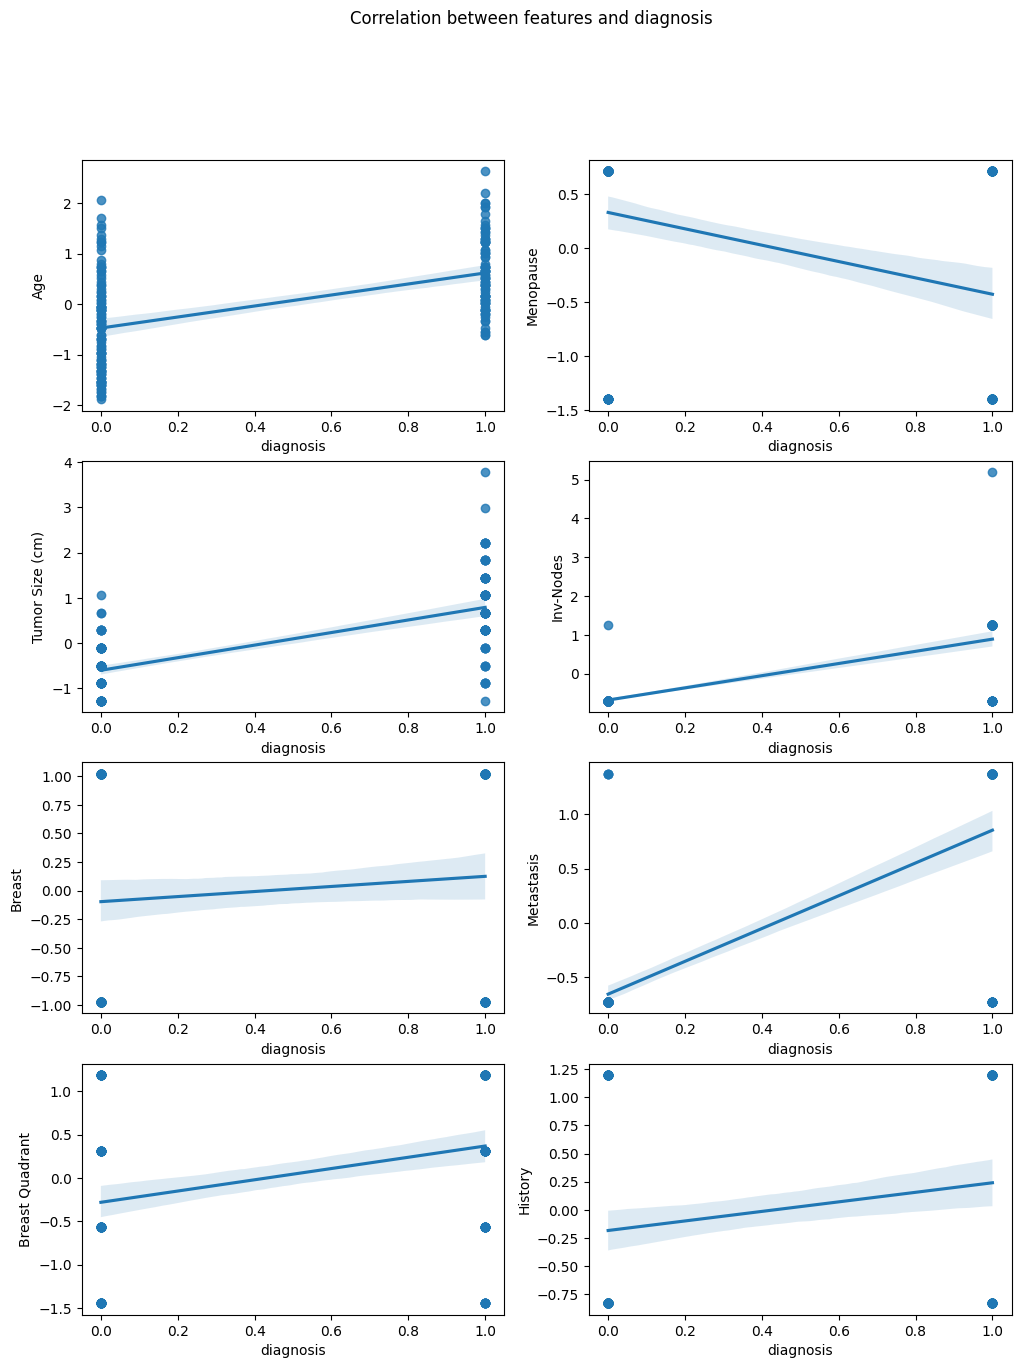

In [735]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15))
fig.suptitle('Correlation between features and diagnosis')
sns.regplot(x='diagnosis', y='Age', data=cancerData, ax=axes[0,0])

sns.regplot(x='diagnosis', y='Menopause', data=cancerData, ax=axes[0,1])

sns.regplot(x='diagnosis', y='Tumor Size (cm)', data=cancerData, ax=axes[1,0])

sns.regplot(x='diagnosis', y='Inv-Nodes', data=cancerData, ax=axes[1,1])

sns.regplot(x='diagnosis', y='Breast', data=cancerData, ax=axes[2,0])
sns.regplot(x='diagnosis', y='Metastasis', data=cancerData, ax=axes[2,1])
sns.regplot(x='diagnosis', y='Breast Quadrant', data=cancerData, ax=axes[3,0])
sns.regplot(x='diagnosis', y='History', data=cancerData, ax=axes[3,1])

<AxesSubplot: xlabel='Age', ylabel='History'>

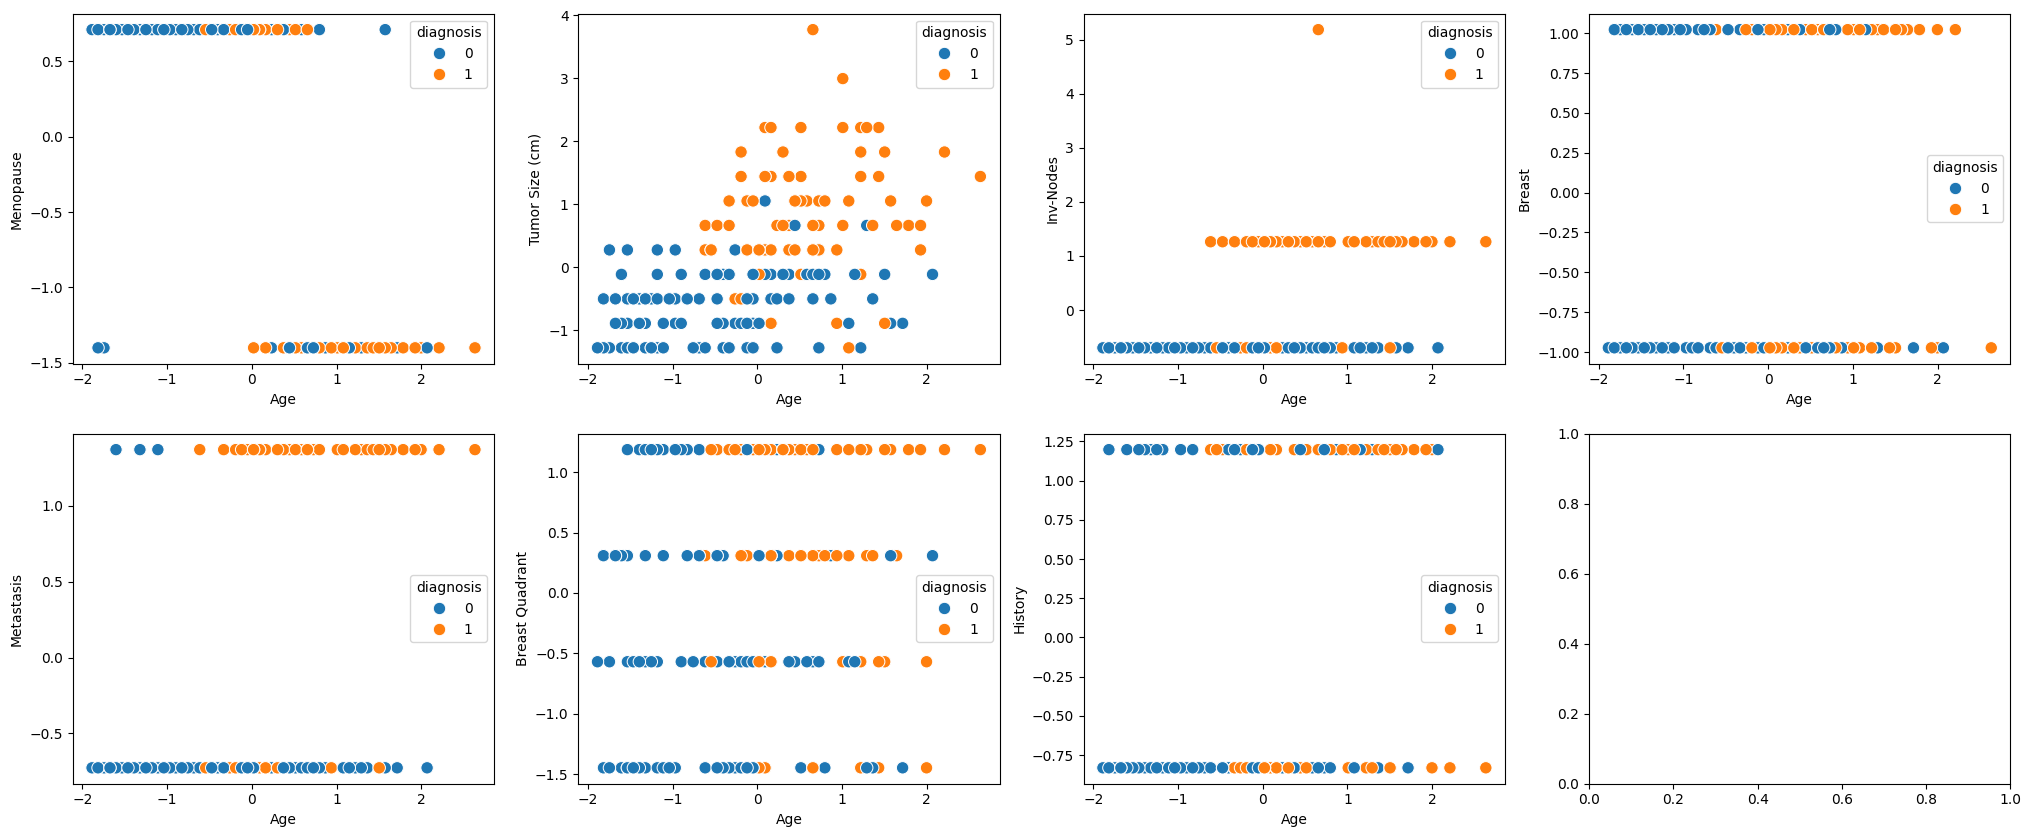

In [755]:
figs, axes = plt.subplots(2, 4, figsize=(25, 10), sharex=False)

sns.scatterplot(x='Age', y='Menopause', data=cancerData, hue='diagnosis', ax=axes[0,0], s=80)
sns.scatterplot(x='Age', y='Tumor Size (cm)', data=cancerData, hue='diagnosis', ax=axes[0,1], s=80)
sns.scatterplot(x='Age', y='Inv-Nodes', data=cancerData, hue='diagnosis', ax=axes[0,2], s=80)
sns.scatterplot(x='Age', y='Breast', data=cancerData, hue='diagnosis', ax=axes[0,3], s=80)
sns.scatterplot(x='Age', y='Metastasis', data=cancerData, hue='diagnosis', ax=axes[1,0], s=80)
sns.scatterplot(x='Age', y='Breast Quadrant', data=cancerData, hue='diagnosis', ax=axes[1,1], s=80)
sns.scatterplot(x='Age', y='History', data=cancerData, hue='diagnosis', ax=axes[1,2], s=80)

C:\Users\Sadra\AppData\Local\Temp\ipykernel_7940\2125686369.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(disease_1["History"], label='D', kde_kws={'bw':1}, ax=axes[0, 0], bins=5)
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2496: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Sadra\AppData\Local\Temp\ipykernel_7940\2125686369.py:6: UserWa

<AxesSubplot: xlabel='Age', ylabel='Density'>

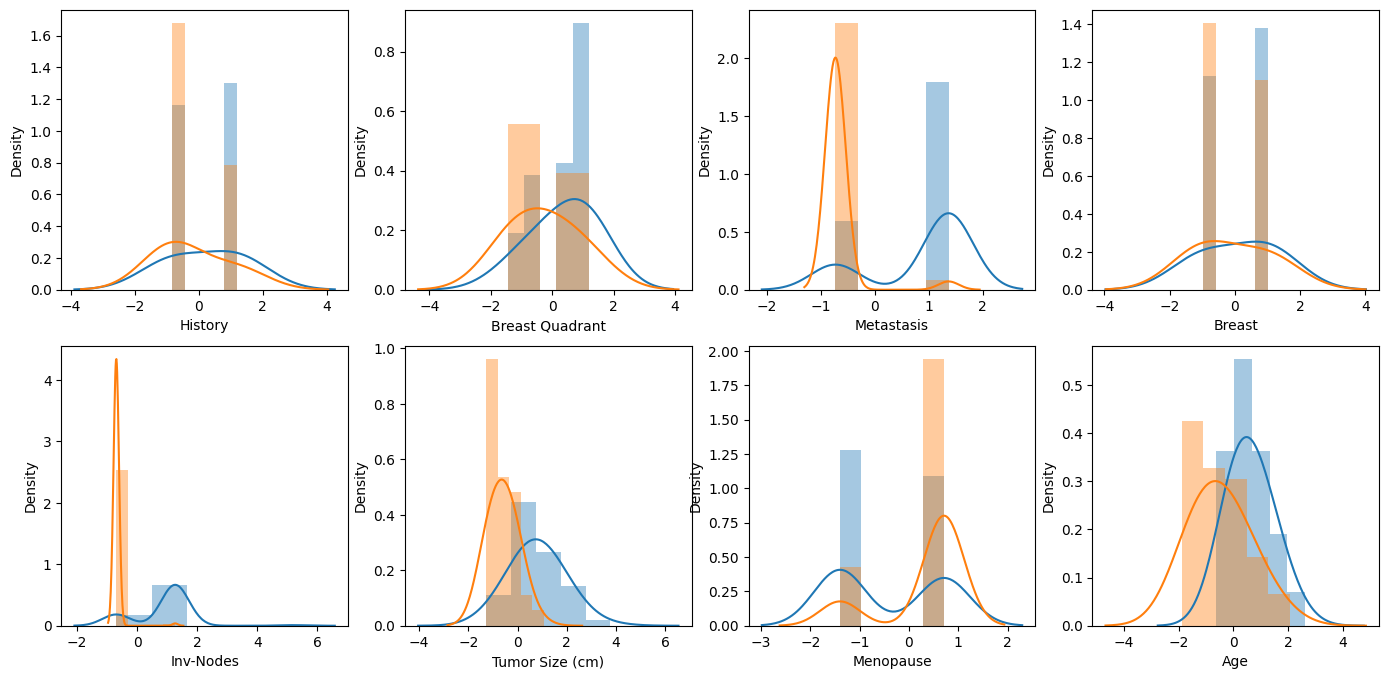

In [761]:
disease_1 = cancerData[cancerData.diagnosis==1]
disease_0 = cancerData[cancerData.diagnosis==0]
figs, axes = plt.subplots(2, 4, figsize=(17, 8), sharex=False)

sns.distplot(disease_1["History"], label='D', kde_kws={'bw':1}, ax=axes[0, 0], bins=5)
sns.distplot(disease_0["History"], label='H', kde_kws={'bw':1}, ax=axes[0, 0], bins=5)

sns.distplot(disease_1["Breast Quadrant"], label='D', kde_kws={'bw':1}, ax=axes[0, 1], bins=5)
sns.distplot(disease_0["Breast Quadrant"], label='H', kde_kws={'bw':1}, ax=axes[0, 1], bins=5)

sns.distplot(disease_1["Metastasis"], label='D', kde_kws={'bw':0.5}, ax=axes[0, 2], bins=5)
sns.distplot(disease_0["Metastasis"], label='H', kde_kws={'bw':0.5}, ax=axes[0, 2], bins=5)

sns.distplot(disease_1["Breast"], label='D', kde_kws={'bw':1}, ax=axes[0, 3], bins=5)
sns.distplot(disease_0["Breast"], label='H', kde_kws={'bw':1}, ax=axes[0, 3], bins=5)

sns.distplot(disease_1['Inv-Nodes'], label='D', kde_kws={'bw':0.5}, ax=axes[1, 0], bins=5)
sns.distplot(disease_0['Inv-Nodes'], label='H', kde_kws={'bw':0.5}, ax=axes[1, 0], bins=5)

sns.distplot(disease_1["Tumor Size (cm)"], label='D', kde_kws={'bw':1}, ax=axes[1, 1], bins=5)
sns.distplot(disease_0["Tumor Size (cm)"], label='H', kde_kws={'bw':1}, ax=axes[1, 1], bins=5)

sns.distplot(disease_1.Menopause, label='D', kde_kws={'bw':0.5}, ax=axes[1, 2], bins=5)
sns.distplot(disease_0.Menopause, label='H', kde_kws={'bw':0.5}, ax=axes[1, 2], bins=5)

sns.distplot(disease_1.Age, label='D', kde_kws={'bw':1}, ax=axes[1, 3], bins=5)
sns.distplot(disease_0.Age, label='H', kde_kws={'bw':1}, ax=axes[1, 3], bins=5)

### For this part as we see the features named: sg, al, pc, pcv, htn, dm, ane are suitable for further analyses

In [736]:
cancerData.columns

Index(['Age', 'Menopause', 'Tumor Size (cm)', 'Inv-Nodes', 'Breast',
       'Metastasis', 'Breast Quadrant', 'History', 'diagnosis'],
      dtype='object')

In [737]:
# X = kidneyData[["sg", "al", "pc", "pcv", "htn", "dm", "ane"]].values
X = cancerData[['Menopause', 'Metastasis', 'Age', 'Tumor Size (cm)']].values
# Try this commented code instead of the above one to see the difference
# X = kidneyData[['age', 'su', 'pot','wc']].values
y = cancerData["diagnosis"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=39)

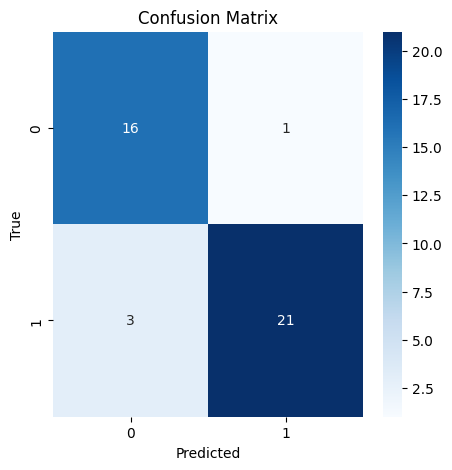

precision=[0.84210526 0.95454545], recall=[0.94117647 0.875     ], f-score=[0.88888889 0.91304348], support=[17 24]


In [738]:
result = knn(best_K, X_train, y_train, X_test, y_test, show_confusion=True)
print(f'precision={result[0]}, recall={result[1]}, f-score={result[2]}, support={result[3]}') 

best k -> 11


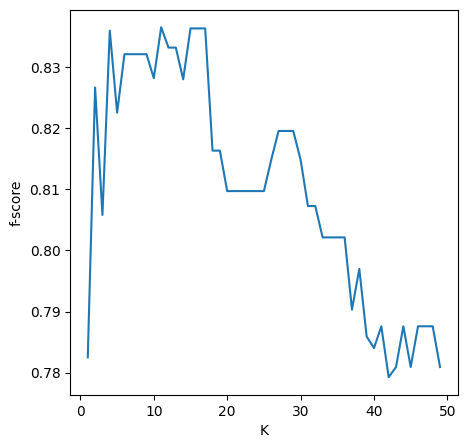

In [739]:
k_range = range(1, 50)
f_scores = [bestK(n, X, y) for n in k_range]
# print(f_scores)
best_K = f_scores.index(max(f_scores)) + 1
plt.figure(figsize=(5, 5))
plt.plot(k_range, f_scores)
plt.xlabel("K")
plt.ylabel("f-score")
print(f"best k -> {f_scores.index(max(f_scores)) + 1}")

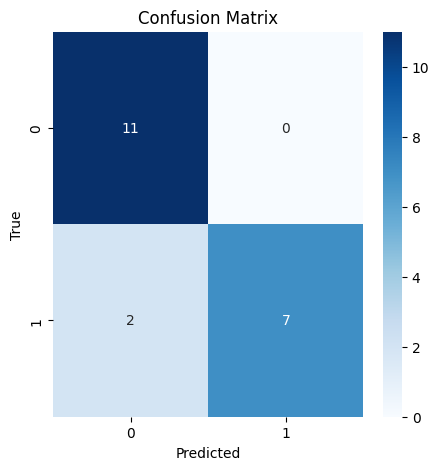

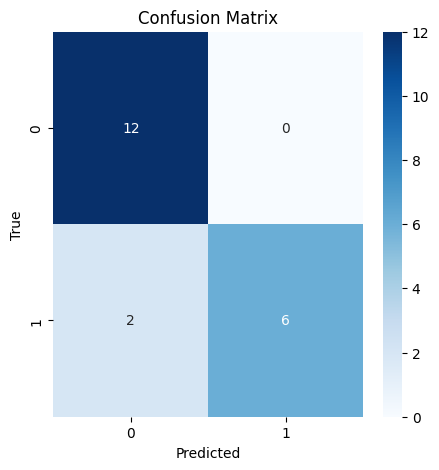

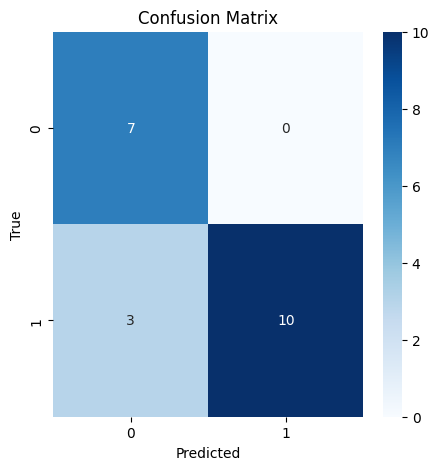

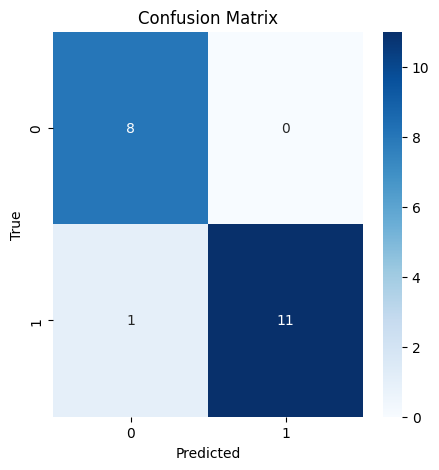

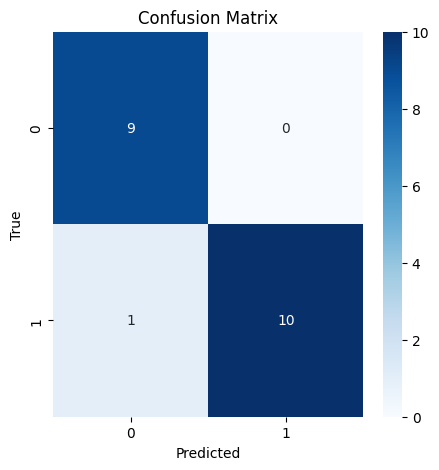

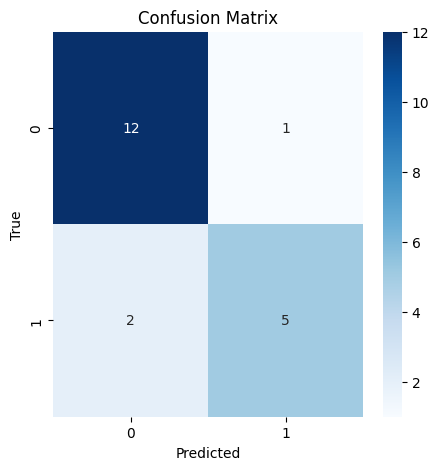

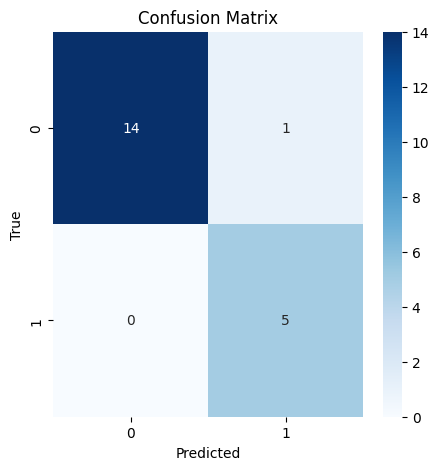

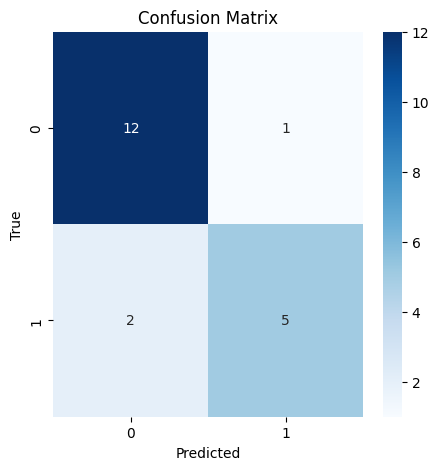

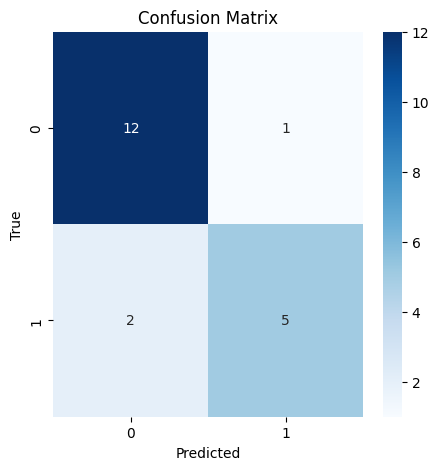

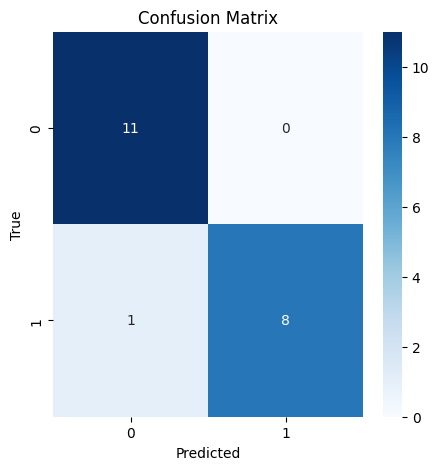

recall_0 -> [1.0, 1.0, 1.0, 1.0, 1.0, 0.9230769230769231, 0.9333333333333333, 0.9230769230769231, 0.9230769230769231, 1.0]
mean recall_0 -> 0.9702564102564102
recall_1 -> [0.7777777777777778, 0.75, 0.7692307692307693, 0.9166666666666666, 0.9090909090909091, 0.7142857142857143, 1.0, 0.7142857142857143, 0.7142857142857143, 0.8888888888888888]
mean recall_1 -> 0.8154512154512155
precision_0 -> [0.8461538461538461, 0.8571428571428571, 0.7, 0.8888888888888888, 0.9, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.9166666666666666]
mean precision_0 -> 0.8680280830280831
precision_1 -> [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 1.0]
mean precision_1 -> 0.9333333333333333
f-score_0 -> [0.9166666666666666, 0.923076923076923, 0.8235294117647058, 0.9411764705882353, 0.9473684210526316, 0.888888888888889, 0.9655172413793104, 0.888888888888889, 0.888888888888889, 0.9565217391304348]
mean f-score_0 -> 0.9140523540325575

In [740]:
k_fold = 10

# Calculate the number of samples per fold
fold_size = len(X) // k_fold
np.random.seed(42)
# Shuffle the dataset
X = np.array(X)
y = np.array(y)

# Shuffle the indices array
indices = np.arange(len(X))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle both X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f_score_0 = []
f_score_1 = []
support_0 = []
support_1 = []

for fold in range(k_fold):
    # Split the dataset into training and testing sets for this fold
    test_start = fold * fold_size
    test_end = (fold + 1) * fold_size
    X_test_fold = X_shuffled[test_start:test_end]
    y_test_fold = y_shuffled[test_start:test_end]
    
    
    # Use the remaining data as training set
    X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
    y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
    result = knn(best_K, X_train_fold, y_train_fold, X_test_fold, y_test_fold, show_confusion=True)
    # print(result)
    precision_0.append(result[0][0])
    precision_1.append(result[0][1])
    recall_0.append(result[1][0])
    recall_1.append(result[1][1])
    f_score_0.append(result[2][0])
    f_score_1.append(result[2][1])
    support_0.append(result[3][0])
    support_1.append(result[3][1])

print(f"recall_0 -> {(recall_0)}")
print(f"mean recall_0 -> {np.mean(recall_0)}")
print(f"recall_1 -> {(recall_1)}")
print(f"mean recall_1 -> {np.mean(recall_1)}")
print(f"precision_0 -> {(precision_0)}")
print(f"mean precision_0 -> {np.mean(precision_0)}")
print(f"precision_1 -> {(precision_1)}")
print(f"mean precision_1 -> {np.mean(precision_1)}")
print(f"f-score_0 -> {(f_score_0)}")
print(f"mean f-score_0 -> {np.mean(f_score_0)}")
print(f"f-score_1 -> {(f_score_1)}")
print(f"mean f-score_1 -> {np.mean(f_score_1)}")
print(f"support 0 -> {support_0}")
print(f"support 1 -> {support_1}")


### Based on the type of dataset that we have and the good feature selection we have done we are getting a high value in all these test but if we add a feature that does not have a high correlation with disease we may lose the results.